In [1]:
## forecasting trail traffic using ARIMA, SARIMAX
## trail data: Cheshire, Hamden, New Haven

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
from datetime import date
from datetime import datetime
%matplotlib inline

In [3]:
# read data
df = pd.read_csv('trail.csv', usecols=['Date','Hamden'])

df['Date']=pd.to_datetime(df['Date'])
print(df.head())

# imputation
df['Hamden'].fillna(0,inplace=True)

df = df.set_index('Date')
df['Hamden'] = df['Hamden'].apply(pd.to_numeric, errors='ignore')

print(df.head(5))


        Date  Hamden
0 2016-11-19     NaN
1 2016-11-20     NaN
2 2016-11-21     NaN
3 2016-11-22     NaN
4 2016-11-23     NaN
            Hamden
Date              
2016-11-19     0.0
2016-11-20     0.0
2016-11-21     0.0
2016-11-22     0.0
2016-11-23     0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


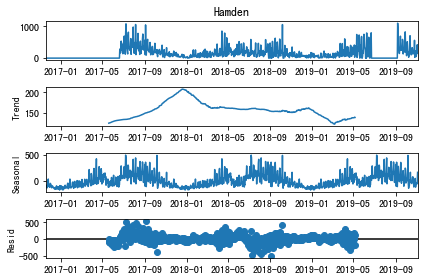

In [4]:
# return with trend, seasonal, and residual
result = sm.tsa.seasonal_decompose(df.Hamden, freq=365)
result.plot()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


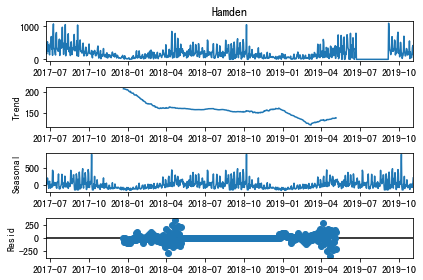

In [5]:
# drop the days before sensor installation, then see the trend again
df =df[215:]
# return with trend, seasonal, and residual
result = sm.tsa.seasonal_decompose(df.Hamden, freq=365)
result.plot()
plt.show()

## ARIMA

In [6]:
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [7]:
warnings.filterwarnings('ignore')

In [8]:
df_month = df.resample('M').mean()
df_q = df.resample('Q-DEC').mean()
df_year = df.resample('A-dec').mean()
print(df_month)
#print(df_q)
#print(df_year)  #

                Hamden
Date                  
2017-06-30  293.555556
2017-07-31  441.451613
2017-08-31  391.064516
2017-09-30  289.933333
2017-10-31  180.483871
2017-11-30  122.766667
2017-12-31   61.064516
2018-01-31   66.322581
2018-02-28  111.500000
2018-03-31  130.967742
2018-04-30  228.933333
2018-05-31  207.967742
2018-06-30  227.933333
2018-07-31  190.806452
2018-08-31  184.838710
2018-09-30  240.500000
2018-10-31  158.548387
2018-11-30   92.366667
2018-12-31   66.032258
2019-01-31   53.935484
2019-02-28   66.250000
2019-03-31  110.774194
2019-04-30  209.666667
2019-05-31  265.870968
2019-06-30  239.733333
2019-07-31    0.000000
2019-08-31    0.000000
2019-09-30  334.066667
2019-10-31  213.322581
2019-11-30  269.750000


In [9]:
#print(df_q)  #11 rows
print(df_year)  #3 rows

                Hamden
Date                  
2017-12-31  250.357513
2018-12-31  158.860274
2019-12-31  150.646104


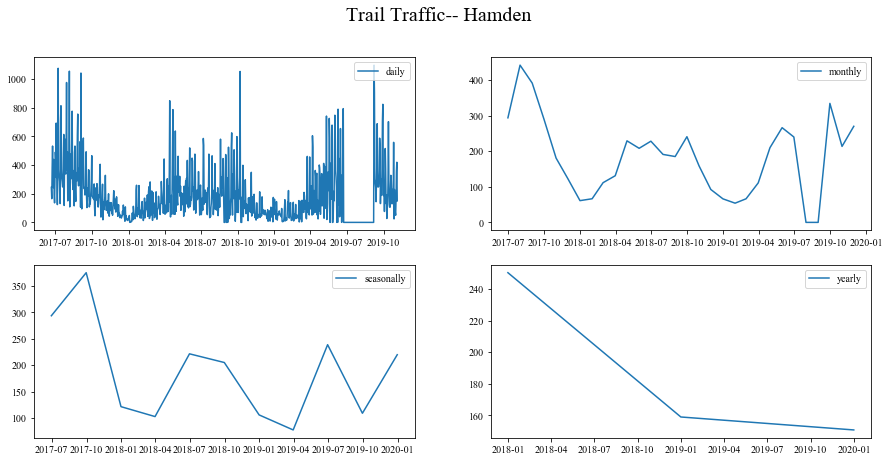

In [10]:
# show trend
fig = plt.figure(figsize=[15,7])
plt.rcParams['font.sans-serif']=['Times New Roman']  
plt.suptitle('Trail Traffic-- Hamden',fontsize=20)
plt.subplot(221)
plt.plot(df.Hamden,'-',label='daily')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Hamden,'-',label='monthly')
plt.legend()
plt.subplot(223)
plt.plot(df_q.Hamden,'-',label='seasonally')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Hamden,'-',label='yearly')
plt.legend()
plt.show()


In [11]:
# set ps q parameter ranges
ps = range(0,3)
qs = range(0,3)
ds = range(0,2)
parameters = product(ps,qs,ds)
parameters_list = list(parameters)
# seeking for optimal ARMA parameters (smallest best_aic)
results=[]
best_aic =float("inf")  # infinite
for param in parameters_list:
    try:
        model = ARIMA(df_month.Hamden, order=(param[0],param[1],param[2])).fit()
    except ValueError:
        print('wrong parameters:',param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param =param
    results.append([param,model.aic])
# print the best results
print('Optimal model:', best_model.summary())


Optimal model:                              ARIMA Model Results                              
Dep. Variable:              D2.Hamden   No. Observations:                   28
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -170.420
Method:                       css-mle   S.D. of innovations            100.224
Date:                Sun, 20 Sep 2020   AIC                            346.840
Time:                        15:38:43   BIC                            350.837
Sample:                    08-31-2017   HQIC                           348.062
                         - 11-30-2019                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4774      2.224      0.664      0.507      -2.882       5.837
ma.L1.D2.Hamden    -0.9999      0.094    -10.667      0.000      -1.184      -0.816
                 

In [12]:
from sklearn.metrics import mean_squared_error
#import itertools 


# seeking for the optimal model with the min aic
results=[]
best_aic = float("inf")
for param in parameters_list:
    try:
        #model = ARIMA(df_month.Price,
                      #order=(param[0], param[1], param[2])).fit()
        # SARIMAX:Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors. 
        # more examples of SARIMAX see: https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html
        model = sm.tsa.statespace.SARIMAX(df_month.Hamden,
                                order=(param[0], param[1], param[2]),  #(p,d,q)
                                seasonal_order=(0, 2, 1, 12),  #(P,D,Q,s) order, 
                                #s is periodicity of the seasons, often is 4 for quarterly data, and 12 for monthly
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('wrong para:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
print('optimao model:',best_model.summary())

optimao model:                                  SARIMAX Results                                  
Dep. Variable:                     Hamden   No. Observations:                   30
Model:             SARIMAX(0, 2, [1], 12)   Log Likelihood                   0.000
Date:                    Sun, 20 Sep 2020   AIC                              4.000
Time:                            15:38:45   BIC                                nan
Sample:                        06-30-2017   HQIC                               nan
                             - 11-30-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12            0         -0        nan        nan           0           0
sigma2      3182.7640         -0       -inf      0.000    3182.764    3182.764
Ljung

In [13]:
# set future_month and date_list for forecasting
df_month2 = df_month[['Hamden']]
future_month =3
last_month =pd.to_datetime(df_month2.index[len(df_month2)-1])
print(last_month)

date_list = []
for i in range(future_month):
    # calculate how many days in the next month
    year = last_month.year
    month = last_month.month
    if month ==12:
        month =1
        year =year+1
    else:
        month=month+1
    next_month_days = calendar.monthrange(year,month)[1]
    print(next_month_days)
    last_month =last_month +timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=',date_list)

2019-11-30 00:00:00
31
31
29
date_list= [Timestamp('2019-12-31 00:00:00', freq='M'), Timestamp('2020-01-31 00:00:00', freq='M'), Timestamp('2020-02-29 00:00:00', freq='M')]


In [14]:
# edit the forecasting period
future = pd.DataFrame(index=date_list,columns=df_month.columns)
df_month2 =pd.concat([df_month2,future])

# get_prediction will get a range, then use predicted_mean
df_month2['forecast'] = best_model.get_prediction(start=0, end=len(df_month2)).predicted_mean



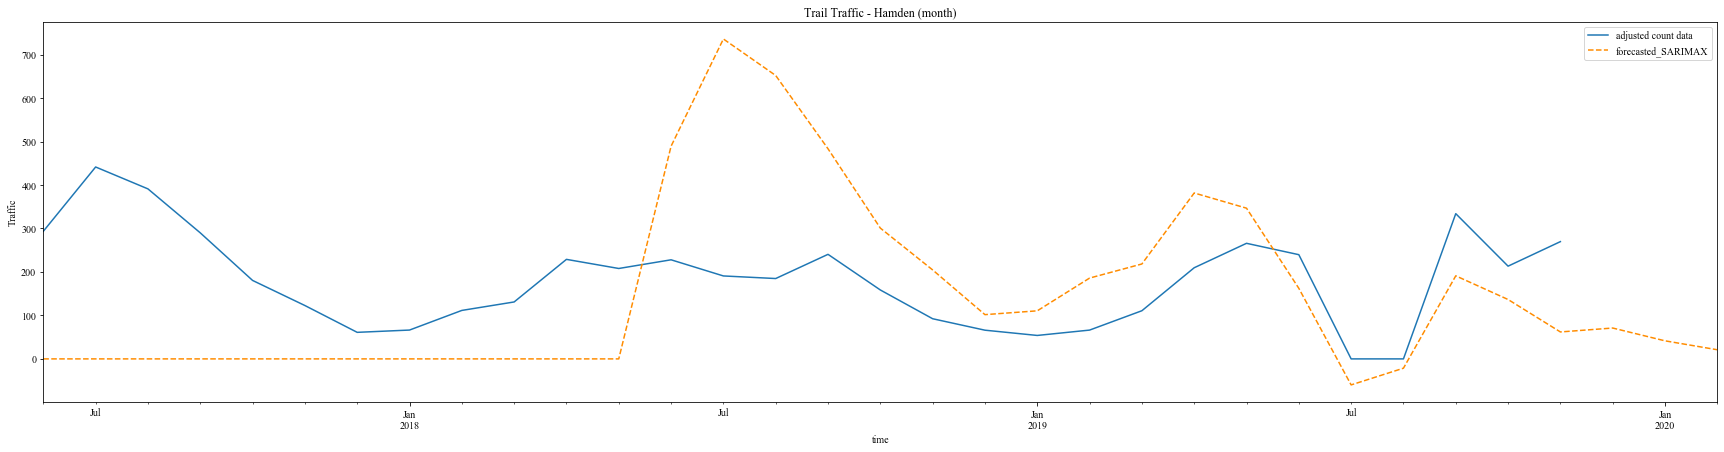

In [15]:
# show predictions
plt.figure(figsize=(30,7))
df_month2.Hamden.plot(label='adjusted count data')
df_month2.forecast.plot(color='darkorange',ls='--',label='forecasted_SARIMAX')
plt.legend()
plt.title('Trail Traffic - Hamden (month)')
plt.xlabel('time')
plt.ylabel('Traffic')
plt.show()